In [4]:
# 임의의 노이즈를 생성하는 가우시안 노이즈 함수
import matplotlib.pyplot as plt
import numpy as np
import torch

In [5]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [6]:
temp = [
    [-0.1,2],[0.3,4],[0.55,6]
]
np.clip(temp,0,1)

array([[0.  , 1.  ],
       [0.3 , 1.  ],
       [0.55, 1.  ]])

In [7]:
data = np.random.normal(
      loc=0,scale=0.8,size=(10,5)
      # 평균 표준편차 크기
  )
gaussian_data_x = np.clip(data,0,1)  # 0,1사이로 정규화
data, gaussian_data_x

(array([[-0.29623264,  0.60521278, -0.69539323, -0.5449644 ,  0.92721283],
        [ 0.19738001, -0.89433328, -0.00318607, -0.1526447 , -1.06332527],
        [ 1.44920852,  0.58165855,  0.59814261, -1.45374553,  0.05331984],
        [-0.14315067, -1.47683753, -0.5402915 ,  0.02641798, -1.30389087],
        [-1.03353378, -0.53415618,  0.59721076,  0.0969653 , -0.80681725],
        [-0.07913507, -0.74375181,  0.31281794,  0.05755994,  0.73400721],
        [ 0.06176474, -0.26074047, -0.80842865, -0.08937365,  0.69648076],
        [-0.25161408,  1.52451618, -1.47262011,  0.29400944,  0.22477514],
        [ 0.79496892,  1.51203824, -0.45715843,  0.31589324,  0.71232174],
        [ 0.74037912, -0.96232534, -0.58887822, -0.44196037,  0.45804294]]),
 array([[0.        , 0.60521278, 0.        , 0.        , 0.92721283],
        [0.19738001, 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.58165855, 0.59814261, 0.        , 0.05331984],
        [0.        , 0.        , 0.   

In [8]:
def gaussian_noise(x, scale=0.8):
  data = x+np.random.normal(
      loc=0,scale=scale,size=x.shape
      # 평균 표준편차 크기
  )
  gaussian_data_x = np.clip(data,0,1)  # 0,1사이로 정규화
  gaussian_data_x = torch.tensor(gaussian_data_x)
  gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
  return gaussian_data_x

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4426746.53it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 129939.48it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1220842.16it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6003948.56it/s]
<ipython-input-8-c00041a711d5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

torch.Size([28, 28])


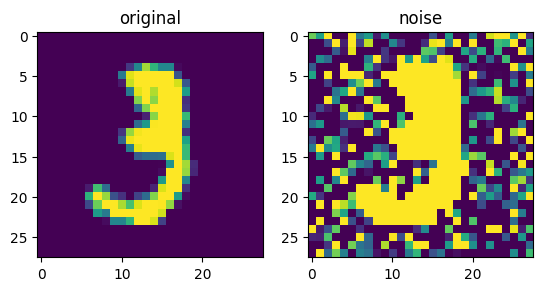

In [9]:
traning_data = MNIST(
    root = './',
    train=True,
    download = True,
    transform=ToTensor()
)
test_data = MNIST(
    root = './',
    train=False,
    download = True,
    transform=ToTensor()
)
# 이미지에 노이즈 추가
# 시각화
img =  traning_data.data[10]
gaussion = gaussian_noise(img)
print(img.shape)

# 두개를 출력
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('noise')
plt.imshow(gaussion)

plt.show()

In [10]:
from torch.utils.data.dataset import Dataset
class GaussianDataset(Dataset):
  def __init__(self):
    self.mnist =  MNIST(
      root = './',
      train=True,
      download = True,
      transform=ToTensor()
    )
    self.data = []
    for i in range(len(self.mnist)):
      data = gaussian_noise( self.mnist.data[i] )
      data = torch.tensor(data)
      self.data.append(torch.unsqueeze(data,dim=0) ) #(28,28) --> (1,28,28)  흑백
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index):
    data = self.data[index]
    label = self.data[index] / 255.0
    return data, label

기본블럭

In [11]:
import torch.nn as nn
class BasicBlock(nn.Module):
  def __init__(self, in_channel,out_channel,hidden_dim) -> None:
    super(BasicBlock,self).__init__()

    self.conv1 = nn.Conv2d(in_channel,hidden_dim,kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(hidden_dim,out_channel,kernel_size=3,padding=1)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    return x

In [12]:
class Encoder(nn.Module):
  def __init__(self) -> None:
    super(Encoder,self).__init__()
    self.basic1 = BasicBlock( in_channel=1,out_channel=16,hidden_dim=16 )
    self.basic2 = BasicBlock( in_channel=16,out_channel=8,hidden_dim=8 )
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # (8,14,14)
  def forward(self, x):
    x = self.pool(self.basic1(x)) # (1,28,28) -> (16,14,14)
    x = self.pool(self.basic2(x)) # (16,14,14) -> (8,7,7)
    return x

디코더 모델

In [13]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.basic1 = BasicBlock(in_channel=8,out_channel=8,hidden_dim=8)
    self.up1 = nn.ConvTranspose2d(in_channels=8,out_channels=8,kernel_size=2,stride=2)

    self.basic2 = BasicBlock(in_channel=8,out_channel=16,hidden_dim=16)
    self.up2 = nn.ConvTranspose2d(in_channels=16,out_channels=16,kernel_size=2,stride=2)

    self.conv1 = nn.Conv2d(in_channels=16,out_channels=1,kernel_size=3,padding=1)
  def forward(self, x):
    x = self.up1(self.basic1(x))  # (8,7,7) -> (8,14,14)
    x = self.up2(self.basic2(x))  # (8,14,14)->(16,28,28)
    x = self.conv1(x) #  (16,28,28) - >(1,28,28)
    return x


In [14]:
class CAE(nn.Module):
  def __init__(self):
    super(CAE,self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
  def forward(self, x):
    x = self.decoder(self.encoder(x))  # (1,28,28)  --> 컨볼류션과같은 레이어를 위해서 채널 차원을 추가(원본에다가)
    x = torch.squeeze(x,dim=0)  # 채널 삭제  (28,28)
    return x

학습

In [15]:
1e-3

0.001

In [16]:
# 데이터셋
# 데이터로더
# 에포크만큼 순환
# 옵티마이져
# 모델로드
from tqdm import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
trainset = GaussianDataset()
train_loader = DataLoader(trainset,batch_size=32)
model = CAE().to(device)

lr = 0.001
optim = Adam(model.parameters(),lr=lr)

for epoch in range(20):
  iterator =  tqdm(train_loader)
  for data, label in iterator:
    optim.zero_grad()
    pred = model(data.to(device))
    loss = nn.MSELoss()(torch.squeeze(pred,dim=0), label.to(device) )
    loss.backward()
    optim.step()

    iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
torch.save(model.state_dict(), './CAE.pth')

<ipython-input-8-c00041a711d5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
<ipython-input-10-55b9e4e957ad>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)
epoch:20 loss:1.2929333479405614e-06: 100%|██████████| 1875/1875 [00:13<00:00, 134.22it/s]


<ipython-input-8-c00041a711d5>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


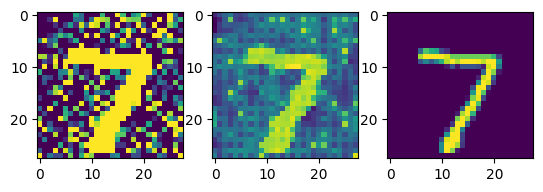

In [17]:
model.cpu()  #  모델의 출력값을 cpu로 이동

with torch.no_grad():
   # 학습이 완료된 가중치를 불러오기
   model.load_state_dict(torch.load("./CAE.pth", map_location=device))

   img = test_data.data[0]         # 시각화에 사용할 이미지 한 장을 불러오기
   gaussian = gaussian_noise(img)  # 이미지에 가우스 잡음을 입히기
   input = torch.unsqueeze(gaussian, dim=0) # 모델의 입력 모양에 맞춰 채널 차원 추가
   input.type(torch.FloatTensor)  #  가중치와 입력의 데이터형을 맞춤
   input.to(device)
   input = torch.unsqueeze(input, dim=0)  # 배치 크기1을 위한 배치 차원을 추가

   plt.subplot(1, 3, 1)
   plt.imshow(torch.squeeze(gaussian))
   plt.subplot(1, 3, 2)
   plt.imshow(torch.squeeze(model(input)))
   plt.subplot(1, 3, 3)
   plt.imshow(torch.squeeze(img))
   plt.show()

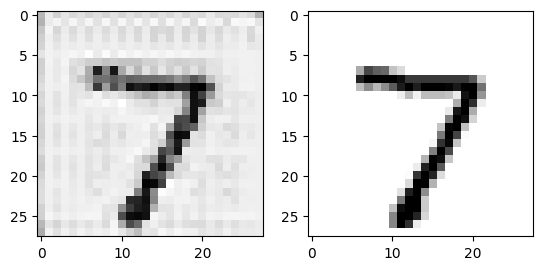

In [18]:
# 노이즈 처리한 이미말고 원본이미지를 모델에 적용
model.cpu()  #  모델의 출력값을 cpu로 이동

with torch.no_grad():
   # 학습이 완료된 가중치를 불러오기
   model.load_state_dict(torch.load("./CAE.pth", map_location=device))

   img = test_data.data[0]/255.0         # 시각화에 사용할 이미지 한 장을 불러오기
   input = torch.unsqueeze(img, dim=0) # 모델의 입력 모양에 맞춰 채널 차원 추가
   input.type(torch.FloatTensor)  #  가중치와 입력의 데이터형을 맞춤
   input = torch.unsqueeze(input, dim=0)  # 배치 크기1을 위한 배치 차원을 추가
   pred = model(input)

   plt.subplot(1, 2, 1)
   plt.imshow(torch.squeeze(pred),cmap='gray_r')
   plt.subplot(1, 2, 2)
   plt.imshow(torch.squeeze(img),cmap='gray_r')
   plt.show()

In [19]:
# 이미지를 데이터
import numpy as np
from PIL import Image
from torchvision.transforms import Resize,ToTensor,Compose


# RGB  LAB(L흑백, AB 색체)

flower_img = Image.open('/content/flower.jpg')
# flower_array = np.array(flower_img)
flower_img = flower_img.convert('L')  # 그레이스케일로 변환(흑백)

# RGB에 대한 컬러형태로 맞춰줌
transforms = Compose([
    # Resize((28,28)),
    ToTensor()
])
flower_img = transforms(flower_img)
print(flower_img.shape)

torch.Size([1, 185, 273])


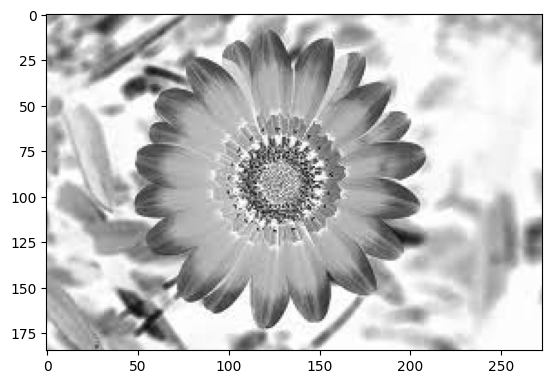

In [20]:
import matplotlib.pyplot as plt
import torch
plt.imshow(torch.squeeze(flower_img), cmap='gray_r')

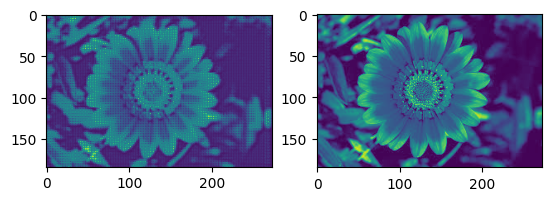

In [21]:
# 노이즈 처리한 이미말고 원본이미지를 모델에 적용
model.cpu()  #  모델의 출력값을 cpu로 이동

with torch.no_grad():
   # 학습이 완료된 가중치를 불러오기
   model.load_state_dict(torch.load("./CAE.pth", map_location=device))

   img = flower_img
   input = img
   input.type(torch.FloatTensor)  #  가중치와 입력의 데이터형을 맞춤
   input = torch.unsqueeze(input, dim=0)  # 배치 크기1을 위한 배치 차원을 추가
   pred = model(input)

   plt.subplot(1, 2, 1)
   plt.imshow(torch.squeeze(pred))
   plt.subplot(1, 2, 2)
   plt.imshow(torch.squeeze(img))
   plt.show()